# Data exploration using ipywidgets

In a [previous post](../widgets-matplotlib.html), I had written about using Matplotlib widgets for data exploration. In this post, I'll use the same data and examples, and visualise using ipywidgets. 

### Setting the backend to Notebook

In [1]:
%matplotlib notebook

### Customary imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

### Creating the data

In [3]:
# Fixing the seed for reproducibility
np.random.seed(0)
df = pd.DataFrame(np.random.randn(365, 15), index=pd.DatetimeIndex(start='2017',freq='D', periods=365))

In [4]:
df.head()[range(5)]

,0,1,2,3,4
2017-01-01,1.764052,0.400157,0.978738,2.240893,1.867558
2017-01-02,0.333674,1.494079,-0.205158,0.313068,-0.854096
2017-01-03,0.154947,0.378163,-0.887786,-1.980796,-0.347912
2017-01-04,-0.438074,-1.252795,0.777490,-1.613898,-0.212740
2017-01-05,-0.672460,-0.359553,-0.813146,-1.726283,0.177426


<IPython.core.display.Javascript object>


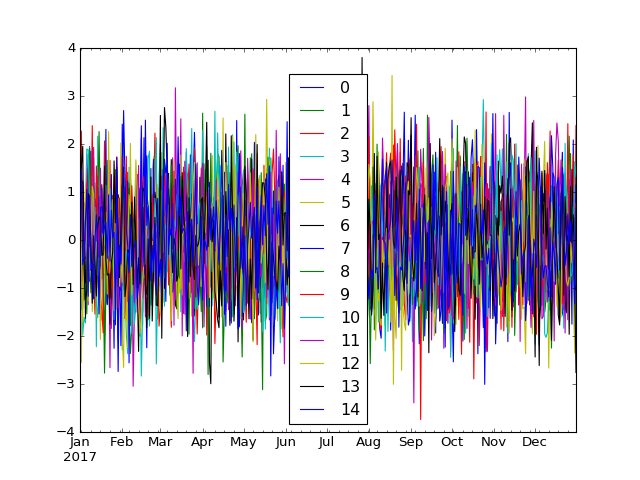

In [5]:
fig, ax  = plt.subplots()
df.plot(ax=ax)

This sure does not look pretty. 

In [10]:
from ipywidgets import interact
t=np.arange(0, 1, .01)

def pltsin(f):
    plt.plot(t, np.sin(2*np.pi*t*f))
    print f
    plt.show()

interact(pltsin, f=(1, 10, 0.1))

<function __main__.pltsin>

### Proposed solution

![](mpl-low-res.gif)

Great. It seems to do the intended job. Let us now look at the individual pieces and how we can tie them up.

### Creating the initial frame

In the first frame we would like to plot the data for the first sample.
```python
fig, ax = plt.subplots()
df[0].plot(ax=ax, title="Sample number: 0")
```

### Creating the buttons at the bottom

First, we'd want to make space for the button at the bottom and place them there. We can do this as follows:

```python
from matplotlib.widgets import Button

fig.subplots_adjust(bottom=0.2)

axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
axnext = plt.axes([0.81, 0.05, 0.1, 0.075])

bnext = Button(axnext, '>')
bprev = Button(axprev, '<')
```

### Linking the buttons to functions

We'd next want to call some function each time either of the two buttons are pressed. We would also need a notion of currently selected data point. The idea would be that each time, `>` is pressed, we advance the currently selected point and plot correspondingly.


We'd have to define `next() and prev()` where we increment and decrement the selected data point.

```python

class Index:
    data = df
    selected = 0
    
    def next(self, event):
        self.selected += 1
        ax.cla()
        df[self.selected].plot(ax=ax)
        ax.set_title("Sample number: %d" %self.selected)

    def prev(self, event):
        self.selected -= 1
        ax.cla()
        df[self.selected].plot(ax=ax)
        ax.set_title("Sample number: %d" %self.selected)
```

Here, `ax.cla()` clears the data for the current data point before drawing for the next one. `df[self.selected].plot(ax=ax)` plots for the newly selected data. `ax.set_title("Sample number: %d" %self.selected)` would change the title to reflect the currently used data point.

We can link to callback as follows: 

```python
callback = Index()

bnext.on_clicked(callback.next)
bprev.on_clicked(callback.prev)
```


### Ensuring we do not select data point out of range

If you notice, we simply incremented and decremented the selected data point without considering going beyond (0, number of data points). So, we need to change the call back functions to check that we do not go beyond the range. This would require the following changes to `next()` with the changes to `prev()` being similar.

```python
data_min = 0
data_max = data.shape[1]-1
selected = 0
def next(self, event):
    if self.selected >=self.data_max:
        self.selected = self.data_max
        ax.set_title('Last sample reached. Cannot go forwards')
    else:
        self.selected += 1
        ax.cla()
        df[self.selected].plot(ax=ax)
        ax.set_title("Sample number: %d" %self.selected)
 ```

There you go. This was fairly simple and fun to do, and yet can be very helpful! 

### Complete code

In [7]:
from matplotlib.widgets import Button

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

df[0].plot(ax=ax, title="Sample number: 0")

class Index:
    data = df
    data_min = 0
    data_max = data.shape[1]-1
    selected = 0
    def next(self, event):
        if self.selected >=self.data_max:
            self.selected = self.data_max
            ax.set_title('Last sample reached. Cannot go forwards')
        else:
            self.selected += 1
            ax.cla()
            df[self.selected].plot(ax=ax)
            ax.set_title("Sample number: %d" %self.selected)

    def prev(self, event):
        if self.selected <=self.data_min:
            self.selected = 0
            ax.set_title('First sample reached. Cannot go backwards')
        else:
            self.selected -= 1
            ax.cla()
            df[self.selected].plot(ax=ax)
            ax.set_title("Sample number: %d" %self.selected)
        

callback = Index()
axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
axnext = plt.axes([0.81, 0.05, 0.1, 0.075])

bnext = Button(axnext, '>')
bnext.on_clicked(callback.next)

bprev = Button(axprev, '<')
bprev.on_clicked(callback.prev)

0

### Advanced example

Here is another slightly more advanced wideget use case in action.

![](advanced-widget.gif)

I will just put the code up here and leave the understanding upto the reader as an exercise.

In [8]:
with pd.HDFStore('temp-store.h5', mode='w') as st:

    # 15 home-> 2 columns, 365 rows (daily one reading)
    for home in range(15):
        df = pd.DataFrame(np.random.randn(365, 2), columns=['fridge','microwave'],
                          index=pd.DatetimeIndex(start='2017',freq='D', periods=365))
        df = df.abs()
        st['/home_%d' %home] = df

In [9]:
st = pd.HDFStore('temp-store.h5', mode='r')

In [10]:
from matplotlib.widgets import Button, CheckButtons

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(left=0.2)

home_0 = st['/home_0']

rax = plt.axes([0.02, 0.4, 0.13, 0.2], aspect='equal')

labels = tuple(home_0.columns)
states = tuple([True]*len(labels))
check = CheckButtons(rax, labels, states)


st['/home_0'].plot(ax=ax, title="Sample number: 0").legend(loc=2)
lines = ax.get_lines()

class Index:
    store = st
    data_min = 0
    data_max = len(store.keys())-1
    selected = 0
    st, la = states, labels
    states_dict = dict(zip(la, st))
    def selected_column(self, label):
        self.states_dict[label] = not self.states_dict[label]
        self.plot()
    
    def plot(self):
        ax.cla()
        st['/home_%d' %self.selected].plot(ax=ax, title="Sample number: %d" %self.selected).legend(loc=2)
        lines = ax.get_lines()
        for i ,(l, s) in enumerate(self.states_dict.items()):
            lines[i].set_visible(s)
        plt.legend(loc=1)
        
        
    def next(self, event):
        if self.selected >=self.data_max:
            self.selected = self.data_max
            ax.set_title('Last sample reached. Cannot go forwards')
        else:
            self.selected += 1
            self.plot()
            

    def prev(self, event):
        if self.selected <=self.data_min:
            self.selected = 0
            ax.set_title('First sample reached. Cannot go backwards')
        else:
            self.selected -= 1
            self.plot()
        

callback = Index()
axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
axnext = plt.axes([0.81, 0.05, 0.1, 0.075])

bnext = Button(axnext, '>')
bnext.on_clicked(callback.next)

bprev = Button(axprev, '<')
bprev.on_clicked(callback.prev)

check.on_clicked(callback.selected_column);